# physics724: Advanced Methods of Data Analysis

Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE". Remember to delete the `raise NotImplementedError()` statements as you implement your solutions.

---

# Exercise 5.2: Classification

In this exercise, you will develop and train a machine-learning classifier using 2D polynomial basis functions, following the example laid out on the lecture.

First we load the data from `classification_data.csv`. It contains the columns `x`, `y` and `class`. Your classifier should aim to predict `class` for a given $(x,y)$ tuple.

Text(0.5, 1.0, 'Labelled data')

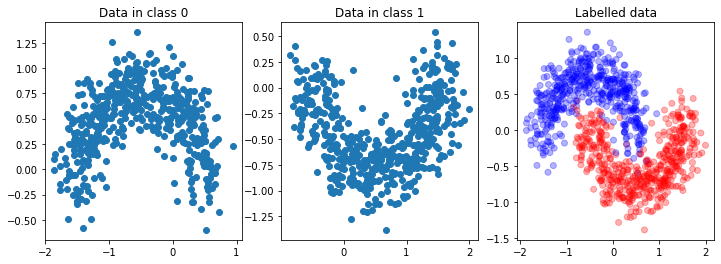

In [2]:
import pandas as pd
df = pd.read_csv("classification_data.csv")

from matplotlib import pyplot as plt
fig,axes = plt.subplots(1,3, figsize=(12,4))
for t in 0,1:
    class_data = df.loc[df["class"] == t]
    axes[t].scatter(class_data["x"], class_data["y"])
    axes[t].set_title(f"Data in class {t}")
axes[2].scatter(df["x"], df["y"], c=df["class"], cmap="bwr", alpha=0.3)
axes[2].set_title("Labelled data")

Your classifier will need a few features to be useful:

### Evaluation of the polynomial function

As in the lecture notes, you should implement a 2D polynomial function that resembles
$$
\phi(x,y|\mathbf{c}) = (c_{00} + c_{10} x + c_{01} y + c_{11} xy + c_{20} x^2 ...)
$$

or more generally

$$
\phi(x,y|\mathbf{c}) = \sum_{i=0}^n \sum_{j=0}^n c_{ij} x^i y^j
$$

where $\mathbf{c}$ is a matrix of coefficients.

Be aware that the CPU time scales very badly with the max degree $n$. A value of 3 or 4 should be sufficient.

### Evaluation of the objective function

Here you can just use a simple quadratic difference, as used in the least squares technique.

$$
f(\vec{(x,y,t)}|\mathbf{c}) = \sum_i \left(t_i - \phi(x_i,y_i|\mathbf{c})\right)^2
$$

where $\sum_i$ denotes the sum over the rows in the dataset $\vec{(x,y,t)}$, and $x$, $y$ and $t$ correspond to the columns `x`, `y` and `class`, respectively.

### Training

Training in this context is just performing a least squares fit to the data in order to obtain the best estimates of the coefficients $\mathbf{\hat{c}}$.

You can use [`scipy.optimize.minimize`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html). Remember that the first argument `fun` is the objective function $f$, not the polynomial function $\phi$. The second argument `x0` is a list of initial guesses of the coefficients.

The `minimize` function will return an `OptimizeResult` object, whose member `x` contains the optimised coefficients.

*e.g.* you can use it like this:
```python
class poly2D:
    #... partial example implementation
    def f(self, c, x, y t):
        """
            c is a list of coefficients
            x, y and t are lists of the same length
        """
        # return the sum of squares of t - \phi(x,y|c)
    def train(self, x, y, t):
        """
            x, y and t are lists of the same length
        """
        result = minimize(fun = self.f, x0 = self.coefficients, args = (x, y, t))
        self.coefficients = result.x
```

### Prediction

Finally, your classifier should be able to predict $t$ given a new value of $x$ and $y$.
This is just a matter of evaluating a "score" $ = \phi(x,y|\mathbf{\hat{c}})$ and choosing a value of $t$ based on a "cut" on that score.

The dataset is constructed such that 0.5 is already the optimal cut:
$$
t(x,y) =
\begin{cases}
    0, & \phi(x,y|\mathbf{\hat{c}}) \leq 0.5 \\
    1, & \phi(x,y|\mathbf{\hat{c}}) > 0.5 \\
\end{cases}
$$

1) Split the data randomly into training and testing samples.

In [15]:
import numpy as np
from numpy import random as rand

train_index = rand.random_integers(0,len(df['x'])-1,int(len(df['x'])/2))

x_train = np.array(df['x'])[train_index]
y_train = np.array(df['y'])[train_index]
t_train = np.array(df['class'])[train_index]

x_test = np.delete(np.array(df['x']),train_index)
y_test = np.delete(np.array(df['y']),train_index)
t_test = np.delete(np.array(df['class']),train_index)

2) Implement the classifier here and find the optimal coefficients $\mathbf{\hat{c}}$ by fitting the training sample.

In [63]:

from scipy.optimize import minimize
# coeff = [c00,c01,c02,c03,c10,c11,c12,c20,c21,c30] ---> cij * x^i * y^j   polynomial of degree 3
#         [0,  1,  2,  3,  4,  5,   6,  7,  8,  9,]

def phi(coeff,x,y):
    phi_xyc = coeff[0] + coeff[1]*y + coeff[2]*(y**2) + coeff[3]*(y**3) + coeff[4]*x + coeff[5]*x*y + coeff[6]*x*(y**2) + coeff[7]*(x**2) + coeff[8]*(x**2)*y + \
    coeff[9]*(x**3)
    return phi_xyc

def obj_func(coeff,x_train,y_train,t_train):
    phi_xyc = phi(coeff,x_train,y_train)
    f = (t_train - phi_xyc)**2
    return(np.sum(f))

x0 = [0 for i in range(10)]
results = minimize(obj_func,x0,(x_train,y_train,t_train))
best_coeff = results.x

In [64]:
print(best_coeff)

[ 0.51908062 -1.1384333  -0.01603148  0.64649504 -0.18253156 -0.00570216
  0.39682132 -0.0204193   0.41238954  0.19169491]


3) Now evaluate the classifier score $\phi(x,y|\mathbf{\hat{c}})$ on the testing sample. Plot histograms of the distributions of the score for each class (*i.e.* each true value of $t$).

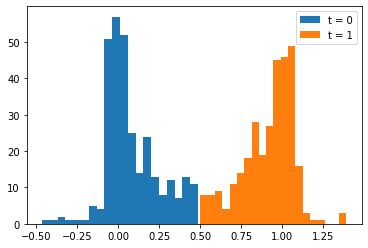

In [58]:
test_phi = phi(best_coeff,x_test,y_test)
class1 = np.extract(test_phi <= 0.5, test_phi)
class2 = np.extract(test_phi > 0.5,test_phi)
plt.hist(class1,label = 't = 0',bins = 20)
plt.hist(class2,label = 't = 1',bins = 20)

plt.legend()


Optional bonus task: create a contour plot in the $x$–$y$ plane visualising the decision boundary $\phi(x,y|\mathbf{\hat{c}}) = 0.5$

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()